In [1]:
import os
from configClassifier import *
from utilsClassifier import *

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import tensorflow as tf
from tensorflow import keras 
from sklearn.metrics import confusion_matrix
import seaborn as sns
from datetime import datetime

import pprint

from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import TensorBoard


ModuleNotFoundError: No module named 'configClassifier'

In [123]:
# CNN to classify rgb images

class ClassifierCNNModel():
    def __init__(self, num_classes=10, batch_size=32, inputShape=(64,64,3), dropout_prob=0.25):
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.inputShape = inputShape
        self.dropout_prob = dropout_prob

    def create_model(self):
        model = Sequential()

        chanDim = -1
        model.add(Conv2D(25, (3, 3), padding="same",
                         input_shape=self.inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3, 3)))
        

        model.add(Conv2D(50, (3, 3), padding="same"))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.1))
        
        model.add(Conv2D(100, (3, 3), padding="same"))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
       
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.1))

        model.add(Flatten())
        model.add(Dense(2048))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        
        model.add(Dropout(0.1))
        

        # softmax classifier
        model.add(Dense(self.num_classes))
        model.add(Activation("softmax"))
     
        return model

    def display_activation(self, activations, col_size, row_size, act_index):
        activation = activations[act_index]
        activation_index = 0
        fig, ax = plt.subplots(row_size, col_size, figsize=(row_size * 2.5, col_size * 1.5))
        fig.suptitle("activations in layer " + str(act_index+1))

        for row in range(0, row_size):
            for col in range(0, col_size):
                ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
                activation_index += 1
        plt.show()

In [124]:
image_shape = (64,64,3)
modelObj = ClassifierCNNModel(num_classes=len(cfg.CLASSES), batch_size=cfg.BATCH_SIZE, inputShape=image_shape, dropout_prob=cfg.DROPOUT_PROB)
model = modelObj.create_model()


{'training_data_dir': '../data/FlyingObjectDataset_10K/training', 'validation_data_dir': '../data/FlyingObjectDataset_10K/validation', 'testing_data_dir': '../data/FlyingObjectDataset_10K/testing', 'fineGrained': True, 'CLASSES': ['square_red', 'square_green', 'square_blue', 'square_yellow', 'triangle_red', 'triangle_green', 'triangle_blue', 'triangle_yellow', 'circular_red', 'circular_green', 'circular_blue', 'circular_yellow'], 'NUM_CLASS': 12, 'GPU': 1, 'DROPOUT_PROB': 0.5, 'IMAGE_WIDTH': 128, 'IMAGE_HEIGHT': 128, 'IMAGE_CHANNEL': 3, 'NUM_EPOCHS': 10, 'BATCH_SIZE': 32, 'LEARNING_RATE': 0.001, 'LR_DECAY_FACTOR': 0.1, 'PRINT_EVERY': 20, 'SAVE_EVERY': 1, 'DEBUG_MODE': True, 'DATA_AUGMENTATION': False}


In [129]:
opt = tf.optimizers.SGD(0.05)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= opt, metrics=['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 128, 128, 25)      700       
_________________________________________________________________
activation_62 (Activation)   (None, 128, 128, 25)      0         
_________________________________________________________________
batch_normalization_47 (Batc (None, 128, 128, 25)      100       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 42, 42, 25)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 42, 42, 50)        11300     
_________________________________________________________________
batch_normalization_48 (Batc (None, 42, 42, 50)        200       
_________________________________________________________________
activation_63 (Activation)   (None, 42, 42, 50)      

In [1]:
#Train the model

history = model.fit(aug_train_batch_generator,
          epochs=3,
          verbose=1,
          steps_per_epoch=(nbr_train_data//cfg.BATCH_SIZE), # total batch number
          validation_steps=(nbr_valid_data // cfg.BATCH_SIZE), # total batch number
          validation_data=aug_valid_batch_generator,
          callbacks=[TensorBoard(log_dir="logs/{}".format(datetime.now().strftime("%Y%m%d-%H%M%S")), write_graph=True, write_images=False,
                                 histogram_freq=0)])


NameError: name 'model' is not defined

In [132]:
# testing model
test_result = model.evaluate(test_batch_generator,
                                       steps=(nbr_test_data//cfg.BATCH_SIZE))
test_loss = round(test_result[0], 4)
test_acc = round(test_result[1], 4)
print("Test Loss: ", str(test_loss), "Test Accuracy: ", str(test_acc))

69/69 [==============================] - 6s 86ms/step - loss: 0.7668 - accuracy: 0.7645
Test Loss:  0.7668 Test Accuracy:  0.7645


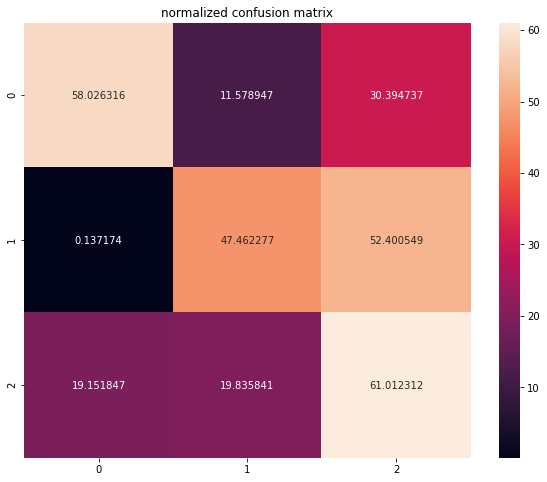

In [30]:
#plot a confusion matrix showing the class-wise accuracies

true_classes = []
pred_classes = []
for i in range(0, nbr_test_data//cfg.BATCH_SIZE +1):
    t_data, t_label = next(test_batch_generator)
    pred_labels = model.predict(t_data, batch_size=cfg.BATCH_SIZE)
    pred_classes.extend(np.argmax(pred_labels, axis=1))
    true_classes.extend(np.argmax(t_label, axis=1))
#print (" true classes: " + str(len(true_classes))  + " pred classes: " + str(len(pred_classes)))
confusion_mtx = confusion_matrix(np.array(true_classes), np.array(pred_classes))
plt.figure(figsize=(10, 8))
plt.title("normalized confusion matrix")
norm_confusion_mtx = 100* confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]
sns.heatmap(norm_confusion_mtx, annot=True, fmt="f")
plt.show()